<font size="20">Point in Polygon Overlay</font>

### This notebook walks you through the process of doing a simple point in polygon overlay

In [22]:
# The import command allows us to call on various libraries
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
%matplotlib notebook

print('Packages Loaded')

Packages Loaded


## Importing the geocoded points

<IPython.core.display.Javascript object>


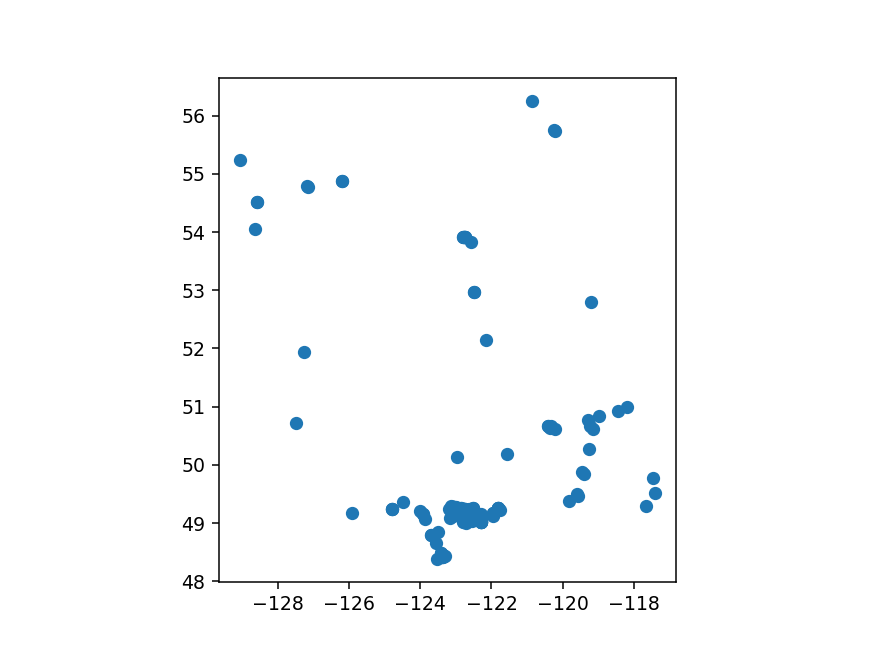

<AxesSubplot:>

In [9]:
BC_Data = pd.read_csv('Data/BC_Geocoded.csv',index_col='id_victim',parse_dates=['date'])
BC_Data_dgf = gpd.GeoDataFrame(BC_Data,
    geometry=gpd.points_from_xy(BC_Data.longitude,
                                BC_Data.latitude,
                                crs=CRS("WGS84")
                               ))
BC_Data_dgf.plot()

# Importing Census Data


<IPython.core.display.Javascript object>


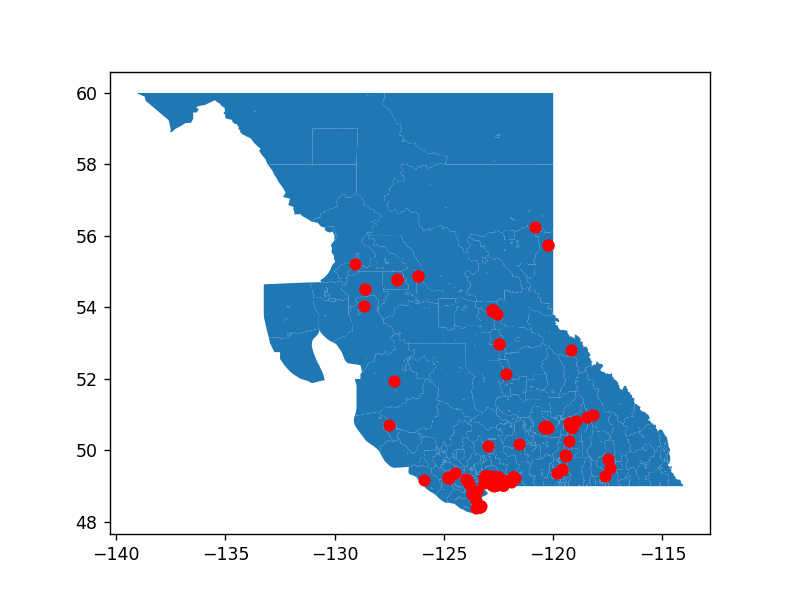

<AxesSubplot:>

In [28]:
# the .read_file() function reads shapefiles
file_name='Data/CensusSubdivisions/SimplyAnalytics_Shapefiles_2021-06-04_04_40_18_c765599d6ce1e70cd26026412f68ed7c.shp'
BC_csd = gpd.read_file(file_name)

BC_csd = BC_csd.rename(columns={
'VALUE0': 'Population, 2016',
                    })

fig,ax=plt.subplots()
BC_csd.plot(ax=ax)
BC_Data_dgf.plot(ax=ax,color='r')

## Intersect

The .within() function does essentially the same thing as the select by location function

<IPython.core.display.Javascript object>


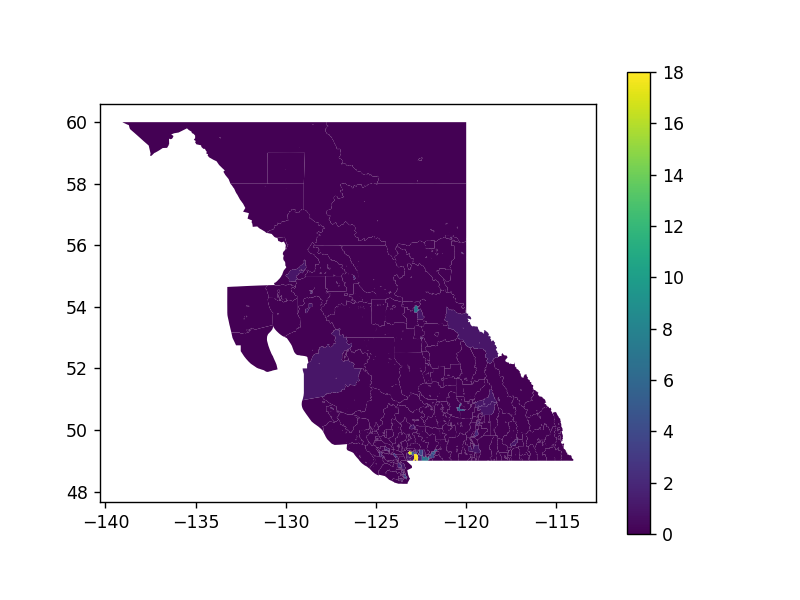

<AxesSubplot:>

In [29]:
BC_csd['Incidents'] = 0
for i,row in BC_csd.iterrows():
    pip = BC_Data_dgf.within(row['geometry'])
    if pip.sum()>0:
        BC_csd.loc[BC_csd.index==i,'Incidents']+=pip.sum()
BC_csd.plot(column='Incidents',legend=True)

## Normalize by population to calcualte the rate of inidents

In [33]:
BC_csd['rate']=BC_csd['Incidents'].astype('float')/BC_csd['Population, 2016']/10*1e6
BC_csd=BC_csd.sort_values('rate').dropna()
# BC_csd = BC_csd.set_index('name')
# print()

# print(BC_Data_dgf.date.min())

BC_csd.loc[BC_csd['rate']>0,['name','Population, 2016','Incidents','rate']].sort_values(by='rate')

,name,"Population, 2016",Incidents,rate
145,"Richmond, BC (CSD)",216320.0,1,0.462278
144,"Delta, BC (CSD)",117169.0,1,0.853468
150,"Coquitlam, BC (CSD)",162399.0,2,1.231535
452,"Kelowna, BC (CSD)",143148.0,2,1.397155
140,"Langley (District municipality), BC (CSD)",131848.0,2,1.516898
463,"Vernon, BC (CSD)",43628.0,1,2.292106
87,"Mission, BC (CSD)",43456.0,1,2.301178
148,"Burnaby, BC (CSD)",259715.0,6,2.310225
149,"New Westminster, BC (CSD)",81568.0,2,2.451942
147,"Vancouver, BC (CSD)",682404.0,17,2.491193


In [36]:
# g = geolocator.geocode('British Columbia, Canada',timeout=3)
# Create a webmap centered on BC at zoom level 5 with the default basemap   
Map = folium.Map(location=[55, -125],zoom_start=5)

BC_csd_select=BC_csd.loc[((BC_csd['rate']>0)&((BC_csd['Population, 2016']>1000)))]
BC_csd_select.to_file("Data/BC_csd_select.json", driver = "GeoJSON")
folium.features.Choropleth('Data/BC_csd_select.json',
                           # It will match the geometry data up with a pandas or geopandas dataframe
                            data=BC_csd_select,
                            columns=['spatial_id','rate'],
                           # They key in the GeoJSON file to match by
                            key_on='feature.properties.spatial_id',
                           # If we define bins, it will split where we tell it to
                            bins = [0,1,5,10,20,100],
                            fill_color='PuRd',
                            fill_opacity = 1,
                            smooth=2,
                           # The legend label
                            legend_name='Population, 2016'
                          ).add_to(Map)
Map